# Monte Carlo Simulations

This notebook is created to test strategies with Monte Carlo simulation by generating random stock price series.

The methodology is as follows:
- Use a statistical distribution based on historical SPY prices to generate series of daily close prices.
- Do Monte Carlo simulations to evaluate the returns of each strategy.

In [11]:
import numpy as np
import pandas as pd
from utils import misc
import matplotlib.pyplot as plt
from scipy.stats import laplace, norm, gmean
from tqdm.notebook import tqdm
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns

from pandas_datareader import data as pdr
import datetime
import yfinance as yf

pd.options.display.max_columns=300
pd.options.display.max_rows=100
pd.core.common.is_list_like = pd.api.types.is_list_like
yf.pdr_override()




Stationary vs Non-stationary time series

Text(0.5, 1.0, 'Non-Stationary')

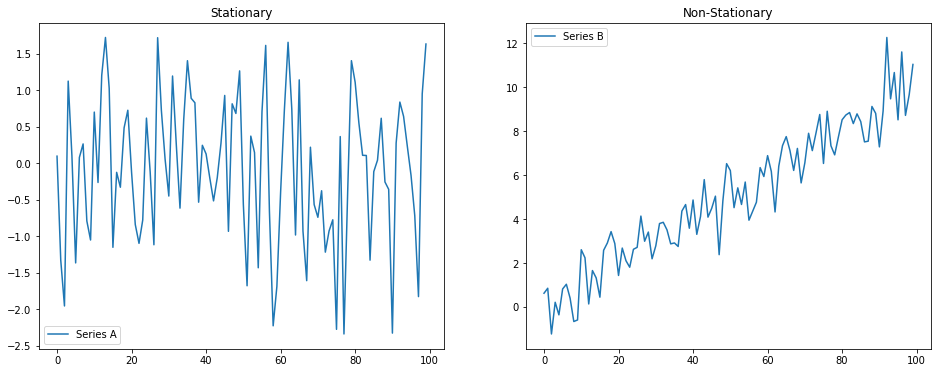

In [12]:
def generate_data(params):
    '''
    Generate data from normal distribution
    '''
    mu = params[0]
    sigma = params[1]   
    return np.random.normal(mu, sigma)

# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T), dtype='float64')
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

B = pd.Series(index=range(T), dtype='float64')
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)
    
fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')

Use Augmented Dickey Fuller (ADF) test for stationarity.

In [13]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

stationarity_test(A)
stationarity_test(B)

p-value = 2.3948531618467858e-11 The series A is likely stationary.
p-value = 0.9487801238477555 The series B is likely non-stationary.


### Cointegration
In general
- Correlation => short term relationship between returns
- Cointegration => long term relationship between prices

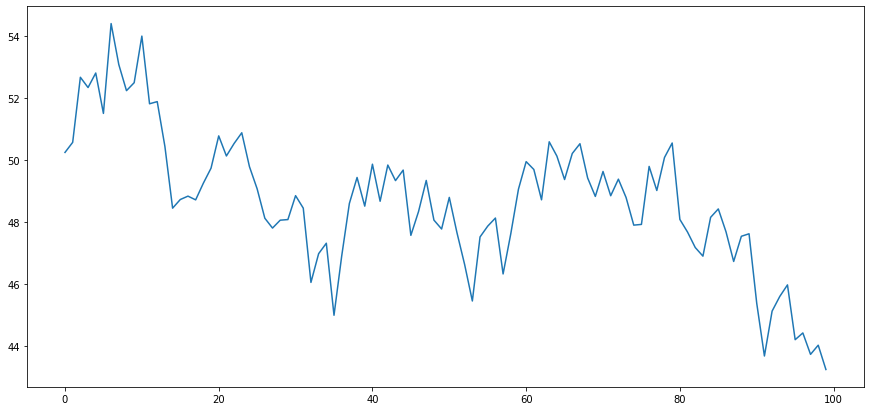

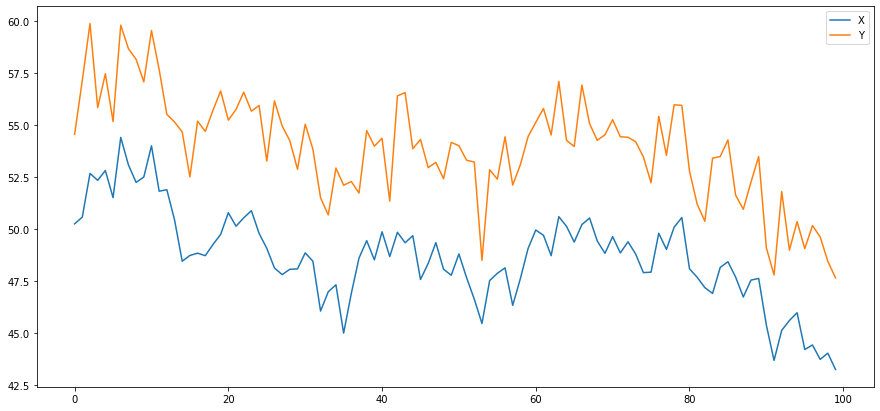

In [14]:
# Generate daily returns

Xreturns = np.random.normal(0, 1, 100)

# sum up and shift the prices up

X = pd.Series(np.cumsum(Xreturns), name='X') + 50
X.plot(figsize=(15,7))

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7))

plt.show()

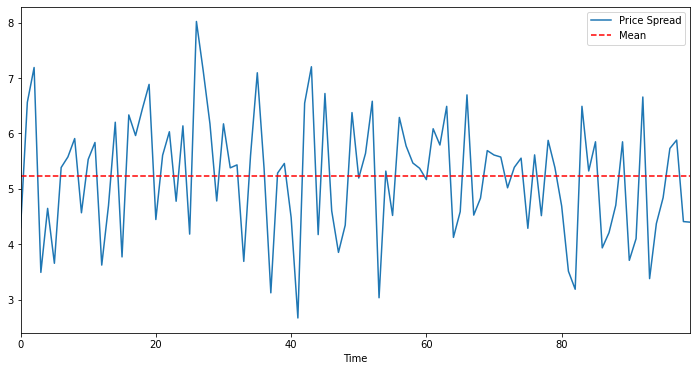

In [15]:
plt.figure(figsize=(12,6))
# Plot the spread
(Y - X).plot() 
# Add the mean
plt.axhline((Y - X).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean']);

In [16]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

# Low pvalue means high cointegration!

1.1540464516850635e-13


Cointegration vs Correlation

Correlation: 0.9975712868066007
Cointegration test p-value: 0.050230901810200596


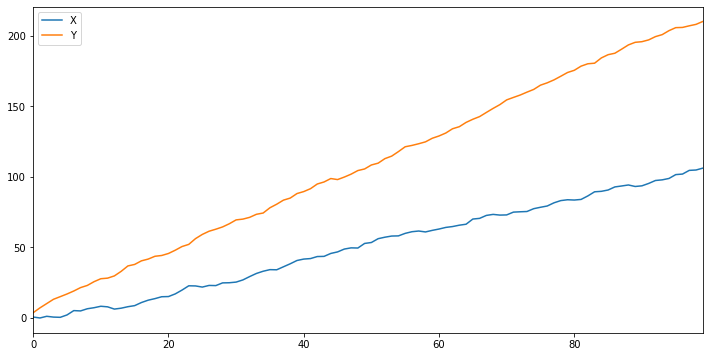

In [17]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')


pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(12,6));
plt.xlim(0, 99);

print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Another example: Normal distribution vs Square wave

Correlation: 0.003196277071770316
Cointegration test p-value: 0.0


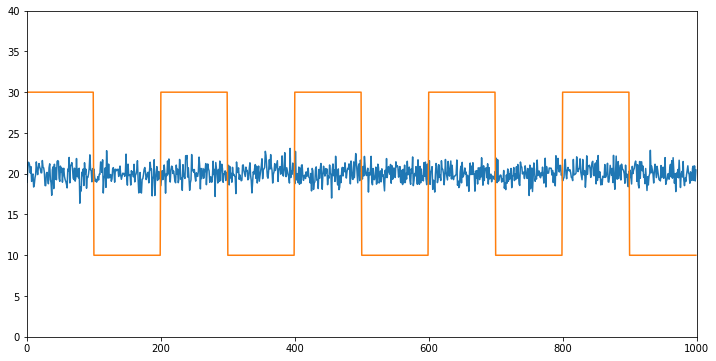

In [18]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000]);

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

In [19]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime.today()

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 completed


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2023-03-06,153.830002,347.019989,81.160004,44.750000,28.570000,130.190002,31.330000,256.869995,89.739998,122.410004,404.470001
2023-03-07,151.600006,344.799988,82.110001,43.980000,27.660000,128.250000,31.200001,254.149994,88.360001,119.190002,398.269989
2023-03-08,152.869995,345.839996,85.370003,44.259998,28.270000,128.050003,31.299999,253.699997,88.489998,121.199997,398.920013
2023-03-09,150.589996,338.369995,84.029999,42.950001,27.889999,126.160004,31.059999,252.320007,86.870003,117.220001,391.559998
2023-03-10,148.500000,329.299988,82.669998,42.040001,27.450001,125.449997,30.799999,248.589996,84.070000,115.190002,385.910004


In [20]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('AMD', 'MSFT'), ('HPQ', 'ORCL'), ('IBM', 'MSFT'), ('IBM', 'ORCL'), ('IBM', 'SPY'), ('JNPR', 'MSFT'), ('JNPR', 'ORCL'), ('JNPR', 'SPY'), ('ORCL', 'SPY')]


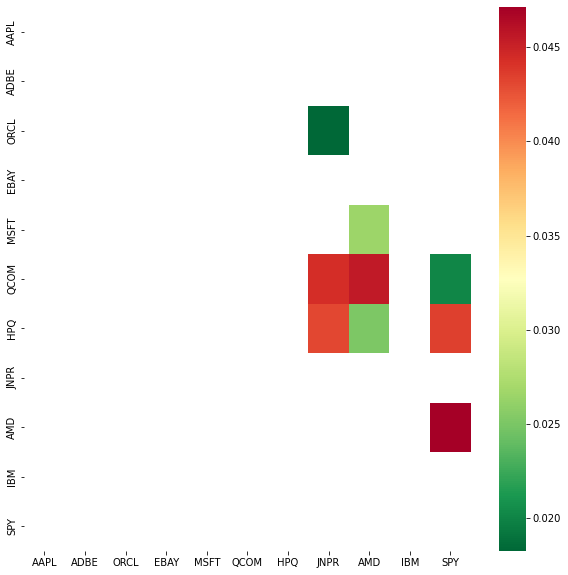

In [21]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' , mask=(pvalues >= 0.05))
print(pairs)

In [22]:
S1 = df['JNPR']
S2 = df['ORCL']

score, pvalue, _ = coint(S1, S2)
pvalue

0.025131070262868982

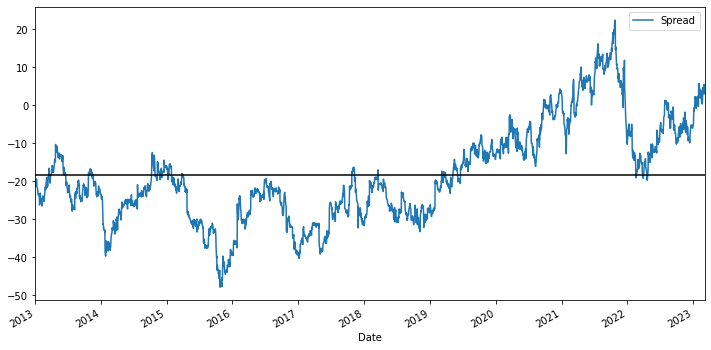

In [23]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['JNPR']
b = results.params['JNPR']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2023-03-07')
plt.legend(['Spread']);

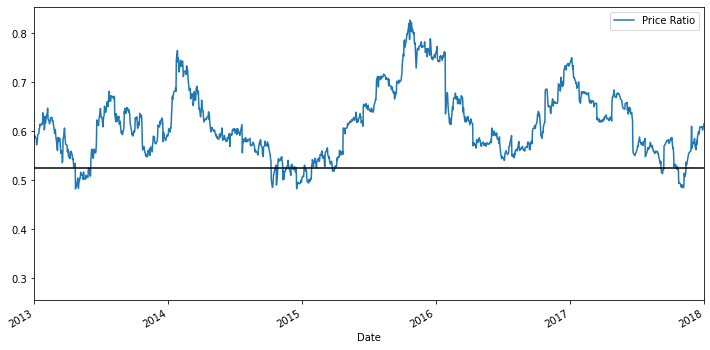

In [24]:
# Examine ratio between the 2 time series
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

Regardless of whether or not we use the spread approach or the ratio approach, we can see that our first plot pair ADBE/SYMC tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

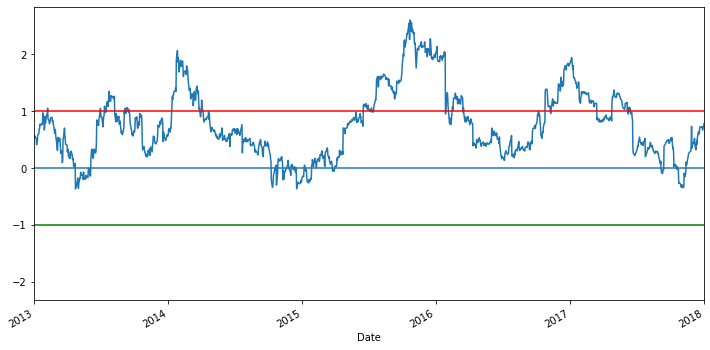

In [25]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

In [26]:
ratios = df['JNPR'] / df['ORCL'] 
print(len(ratios) * .70) 
train = ratios[:1793]
test = ratios[1793:]
test.describe()

1796.1999999999998


count    773.000000
mean       0.384823
std        0.042980
min        0.282358
25%        0.351556
50%        0.388557
75%        0.421211
max        0.482412
dtype: float64

#### Feature Engineering

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score

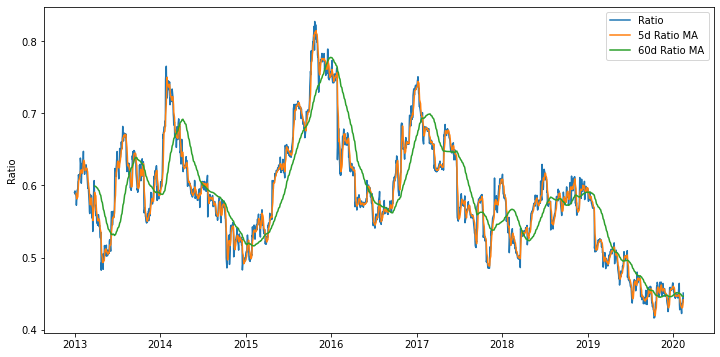

In [27]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60) / std_60

plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

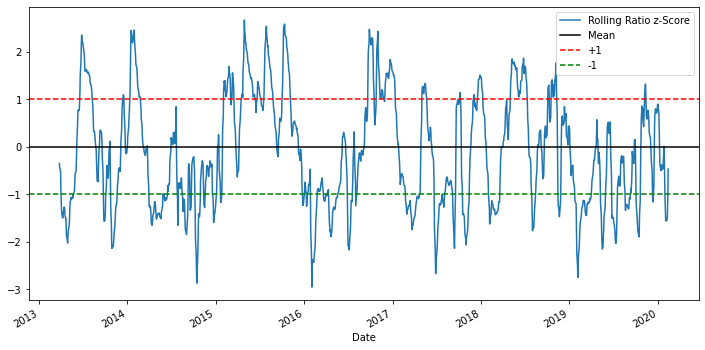

In [28]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
# plt.xlim('2013-01-01', '2023-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

- Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
- Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

<class 'pandas.core.series.Series'>


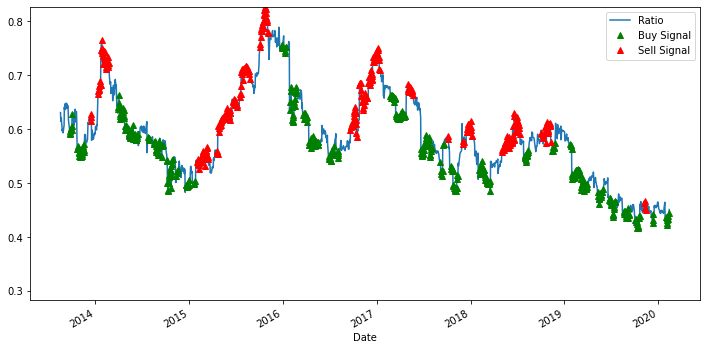

In [43]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
# plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()



Date
2012-12-31    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-07    0.0
             ... 
2016-06-23    0.0
2016-06-24    0.0
2016-06-27    0.0
2016-06-28    0.0
2016-06-29    0.0
Name: JNPR, Length: 881, dtype: float64


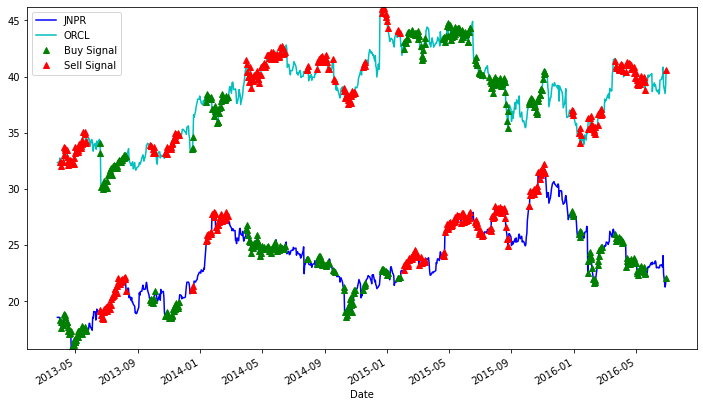

In [41]:
plt.figure(figsize=(12,7))
S1 = df['JNPR'].iloc[:881]
S2 = df['ORCL'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
# plt.ylim(25, 105)
# plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['JNPR', 'ORCL', 'Buy Signal', 'Sell Signal'])
plt.show()

In [39]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            # print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            # print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            # print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [40]:
trade(df['ADBE'].iloc[881:], df['EBAY'].iloc[881:], 60, 5)

6852.359627882983

In [33]:
# Get data from yahoo finance
misc.get_price_data('MSFT')
msft = pd.read_csv('MSFT.csv')
msft = misc.clean_df(msft)
msft = df.set_index('date')
df['close daily change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df = df.dropna()

df

FileNotFoundError: [Errno 2] No such file or directory: 'MSFT.csv'

### Statistics of SPY

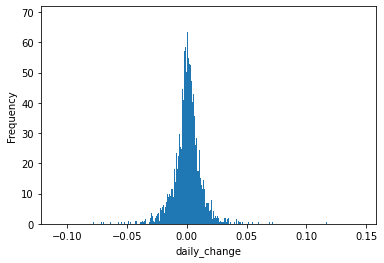

In [ ]:
# Distribution of daily returns
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)
plt.ylabel('Frequency')
plt.xlabel('daily_change')
plt.show()

Normal distribution:

(0.0003645194988266747, 0.011937186906018504)


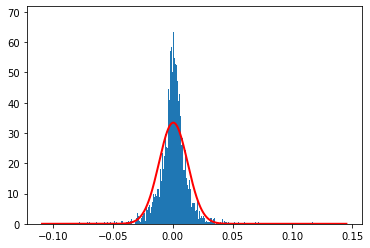

In [ ]:
# Fit normal distribution parameters
norm_params = norm.fit(df['close daily change'])
print(norm_params)

# Plot daily return distribution
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)

# Plot normal distribution with parameters
mu, sigma = norm_params
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

Laplace Distribution:

https://arxiv.org/ftp/arxiv/papers/1906/1906.10325.pdf

(0.0005972544007951823, 0.007939204209947016)


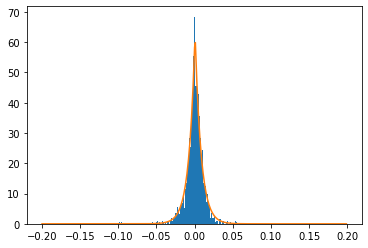

In [ ]:
# Fit Laplace distribution parameters
laplace_params = laplace.fit(df['close daily change'])
print(laplace_params)

# Plot daily returns distribution
count, bins, ignored = plt.hist(df['close daily change'], 1000, density=True)

# Plot Laplace distribution with parameters
loc, scale = laplace_params
x = np.arange(-0.2, 0.2, .001)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)

The laplace distribution appears to be fit SPY daily returns distribution more closely.

We calculate the historical volatility of SPY for use in the BSM equation.

\begin{equation}
    \sigma_{annual} = \sigma_{daily} \times \sqrt{252}
\end{equation}

In [ ]:
spy_hist_vol = np.std(df['close daily change']) * np.sqrt(252)
print("SPY Historical Volatility: " + "{:.2f}".format(spy_hist_vol * 100) + " %")

SPY Historical Volatility: 18.95 %


### Model Stock Replication

We create a model stock by:
- Generating a random series of daily returns distributed by the laplace distribution with previously fitted parameters.
- Specify an initial price.
- Calculate subsequent closing prices by multiplying by daily returns

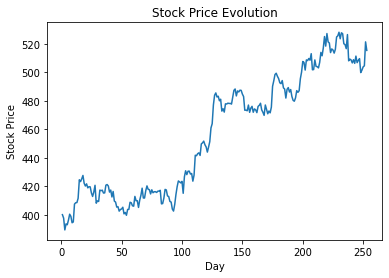

In [ ]:
def generate_stock(laplace_params, num_days=252, initial_price=400):
    '''
    Generate array of stock prices according to laplace distribution
    '''
    # laplace parameters
    loc, scale = laplace_params
    
    # generate daily change from laplace distribution
    s = np.random.laplace(loc, scale, num_days)
    
    # generate stock price from daily change  
    stock_price = np.append(np.ones(1), np.cumprod(s + 1)) * initial_price
        
    return stock_price, s

# set 252 trading days in a year
num_days = 252
stock_price, daily_change = generate_stock(laplace_params, num_days, 400)
t = range(1, num_days + 2)
plt.plot(t, stock_price)

plt.title("Stock Price Evolution")
plt.ylabel('Stock Price')
plt.xlabel('Day')
plt.show()

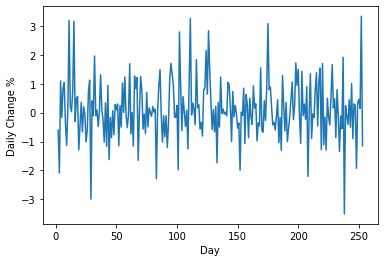

In [ ]:
plt.plot(t[1:], daily_change * 100)
plt.ylabel('Daily Change %')
plt.xlabel('Day')
plt.show()

### Black-Scholes-Merton Equation
BSM equation:

\begin{equation}
    C = N(d_1)S - N(d_2)Ke^{-rt}
\end{equation}

where
- $d_1 = \frac{\ln \frac{S}{K} + (r + \frac{\sigma^2}{2})t}{\sigma\sqrt{t}}$
- $d_2 = d_1 - \sigma\sqrt{t}$
- $C$ is the call option price.
- $N(x)$ is the cummulative distribution function of the normal distribution.
- $S$ is the current price of the underlying.
- $K$ is the strike price of the contract.
- $r$ is the risk-free interest rate (taken as 1 Year US Treasury Bill, $r = 3.26\%$).
- $t$ is the time to maturity.
- $\sigma$ is the volatility.

The BSM equation makes several assumptions:
- Options are european styled, i.e. they cannot be exercised before expiration.
- Volatility remains constant throughout the lifetime of the option.

In [ ]:
def bsm(stock_price, strike_price, dte, volatility=spy_hist_vol, rf_rate=0.03):
    '''
    Calculate the delta and prices of call/put option according to BSM eqn.
    
    Input:
    - current stock price of underlying
    - strike price of contract
    - days to expiry (dte)
    - volatility (historically 17.73% for SPY)
    - risk-free interest rate (3.26% for 1 Year US Treasury Bill)
    
    Output:
    - delta of call option
    - price of call option
    - delta of put option
    - price of put option
    '''
    
    # change units for dte to years
    t = dte / 365.25
    
    # present value of strike price
    pv_strike = strike_price * np.exp(-rf_rate * t)
    
    # d1 and d2 variables of bsm
    d1 = (np.log(stock_price / strike_price) \
          + (rf_rate + (volatility ** 2) / 2) * t) / (volatility * np.sqrt(t))
    d2 = d1 - volatility * np.sqrt(t)
    
    # delta of call option
    call_delta = norm.cdf(d1)
    
    # price of call option
    call_price = call_delta * stock_price - norm.cdf(d2) * pv_strike
    
    # delta of put option
    put_delta = -norm.cdf(-d1)
    
    # price of put option
    put_price = put_delta * stock_price + norm.cdf(-d2) * pv_strike
    
    return call_delta, call_price, put_delta, put_price

### Key Performance Indicators
These are variables that indicate the performance of the strategy.
1. Total Return
2. Compound Annualised Growth Rate
3. Volatility
4. Beta
5. Sharpe Ratio
6. Maximum Drawdown
7. Total Return / Maximum Drawdown

        


In [ ]:
def get_kpi(rt, ch, stock_daily_change):
    '''
    Calculate key performance indicators from daily returns and daily changes of strategy.
    Input: daily returns, daily changes, daily changes
    '''
    kpi_dict = {
            'Total Return': rt[-1] - 1,
            'CAGR': gmean(ch) ** 252 - 1,
            'Volatility': np.std(ch - 1) * np.sqrt(252),
            'Beta': np.corrcoef(stock_daily_change, ch - 1)[0, 1] * np.std(stock_daily_change) * np.std(ch - 1) / np.var(stock_daily_change),
            'Sharpe Ratio': ((np.mean(ch) ** 252 - 1) - 0.03) / (np.std(ch - 1) * np.sqrt(252)),
        }
    
    # Find max return and max drawdown
    max_rt = 0
    max_dd = 0
    for i in range(len(rt)):
        if rt[i] > max_rt:
            max_rt = rt[i]
        else:
            if rt[i] - max_rt < max_dd:
                max_dd = rt[i] - max_rt
    
    kpi_dict['Max Drawdown'] = max_dd
    kpi_dict['RoMaxDD'] = kpi_dict['Total Return'] / (-kpi_dict['Max Drawdown'])
    kpi_dict['Daily Returns'] = rt
    kpi_dict['Daily Changes'] = ch
    
    return kpi_dict


class test:
    def __init__(self, strats_func):
        '''
        strats_func is a function to that runs several strategies at once
        strats_func input: stock price series
        strats_func output: dictionary with strategy names as keys and (daily returns, daily change) as value
        '''
        self.strats_func = strats_func
    
    def kpi_given_stock_price_series(self, stock_price_series, daily_change):
        '''
        Runs strats_func on the stock price series and returns kpi
        '''
        results = self.strats_func(stock_price_series)

        for strat in results:
            rt, ch = results[strat]
            kpi = get_kpi(rt, ch, daily_change)
            results[strat] = kpi

        return results
        
    def single_stock_price_series_expt(self, laplace_params, num_days=252, initial_price=400, display=False):
        '''
        Generates a single stock price series, runs strats_func, and returns kpi
        Statistics and graphs can be displayed
        '''
        # Generate stock price series
        stock_price_series, daily_change = generate_stock(laplace_params, num_days, initial_price)
        
        # Runs strategies and find kpi
        results = self.kpi_given_stock_price_series(stock_price_series, daily_change)

        # Display statistics and graphs
        if display:
            for strat in results:
                kpi = results[strat]

                
                print(strat)
                print('Total Return:          {:.2f} %'.format(kpi['Total Return'] * 100))
                print('CAGR:                  {:.2f} %'.format(kpi['CAGR'] * 100))
                print('Volatility:            {:.2f} %'.format(kpi['Volatility'] * 100))
                print('Beta:                  {:.2f}'.format(kpi['Beta']))
                print('Sharpe Ratio:          {:.2f}'.format(kpi['Sharpe Ratio']))
                print('Max Drawdown:          {:.2f} %'.format(kpi['Max Drawdown'] * 100))
                print('Return over Max DD:    {:.2f}'.format(kpi['RoMaxDD']))
                print('-------------------------------------')

                plt.plot(range(num_days + 1), kpi['Daily Returns'], label=strat)

            plt.xlabel('Time in Days')
            plt.ylabel('Strategy Returns')    
            plt.legend()
            plt.show()
            
        return results

    def multiple_stock_price_series_expt(self, runs, laplace_params, num_days=252, initial_price=400, display=False):
        '''
        Generates multiple stock price series, runs strats_func, and returns average kpi across all runs
        Statistics and graphs can be displayed
        '''
        # Initiate raw results to collect all data
        raw_results = {}


        rng = tqdm(range(runs))

        # Run expt for n times with generated stock price series
        for i in rng:

            # Generate stock price series
            stock_price_series, daily_change = generate_stock(laplace_params, num_days, initial_price)

            # Run strategies and find kpi
            results = self.kpi_given_stock_price_series(stock_price_series, daily_change)

            # Save results
            for strat in results:
                kpi = results[strat]

                # Initialise dict on the 1st run
                if i == 0:
                    raw_results[strat] = []
            
                raw_results[strat].append(kpi)

        # Find average results
        avg_results = {}

        for strat in raw_results:
            avg_results[strat] = {}

            # Average kpi values for all runs
            for key in kpi:
                avg_results[strat][key] = np.mean([f[key] for f in raw_results[strat]])

            # Find winrate of strategy => win = total return at the end of run > 0
            avg_results[strat]['Win-rate'] = np.sum([1 for f in raw_results[strat] if f['Total Return'] > 0]) \
                / runs
            
        
        # display average results
        if display:
            for strat in avg_results:
                print(strat)
                
                print('Total Return:            {:.2f} %'.format(avg_results[strat]['Total Return'] * 100))
                print('CAGR:                    {:.2f} %'.format(avg_results[strat]['CAGR'] * 100))
                print('Volatility:              {:.2f} %'.format(avg_results[strat]['Volatility'] * 100))
                print('Beta:                    {:.2f}'.format(avg_results[strat]['Beta']))
                print('Sharpe Ratio:            {:.2f}'.format(avg_results[strat]['Sharpe Ratio']))
                print('Win-rate:                {:.2f} %'.format(avg_results[strat]['Win-rate'] * 100))
                print('Max Drawdown:            {:.2f} %'.format(avg_results[strat]['Max Drawdown'] * 100))
                print('Return over Max DD:      {:.2f}'.format(avg_results[strat]['RoMaxDD']))
                
                
                print('-------------------------------------')
        
        return avg_results
            




Strategy should return:
1. Daily returns (1.xx)
2. Daily changes in portfolio value (1.xx)

### Buy-Hold Strategy
Buy assets at the start and hold until the end

In [ ]:
def buy_hold_strategy(stock_price):
    arr = stock_price/stock_price[0]
    return arr, arr[1:] / arr[:-1]

Single run results:

Single Run Results:
buy_hold
Total Return:          4.40 %
CAGR:                  4.40 %
Volatility:            16.14 %
Beta:                  1.00
Sharpe Ratio:          0.17
Max Drawdown:          -12.03 %
Return over Max DD:    0.37
-------------------------------------


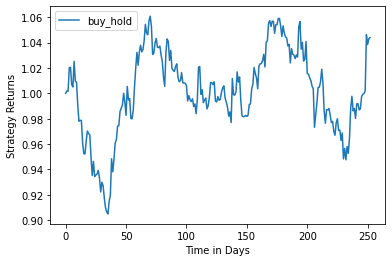

Multiple Run Results:


  0%|          | 0/1000 [00:00<?, ?it/s]

buy_hold
Total Return:            16.91 %
CAGR:                    16.91 %
Volatility:              17.71 %
Beta:                    1.00
Sharpe Ratio:            0.90
Win-rate:                77.60 %
Max Drawdown:            -16.93 %
Return over Max DD:      1.43
-------------------------------------


In [ ]:
def buy_hold_strat_func(stock_price):
    return {'buy_hold': buy_hold_strategy(stock_price)}

buy_hold_test = test(buy_hold_strat_func)

print('Single Run Results:')
_ = buy_hold_test.single_stock_price_series_expt(laplace_params=laplace_params, display=True)
print('Multiple Run Results:')
_ = buy_hold_test.multiple_stock_price_series_expt(1000, laplace_params, display=True)
